In [1]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const


### This tutorial simulates a simple high-res dataset, and uses the cross-correlation methods to recover the signal

*You will need some additional data files: transit.npy and full_transit.npy, which can be found:*
https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/EYFiLHgZgchKtpDqXJtPIkwBkcQaWxVQ4Y0HKhZwSkClrA?e=9oQXN3
*and:*
https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/EeJB-zn7QsVKpHIPJ8q1GWABnGU94a0bAE67UvGVuCGCSA?e=FIyWHH
*These are simple transit models that are used for the weighting.*

We will simulate a simple transit observation, which is a time-series of high-resolution spectra. We'll start by defining some simple planet paramters, and plotting the transit model and velocity.

There's a few important things to note. The transit occurs at phase 0 according to our definitions. The planet's velocity (and therefore atmospheric absorption) is blue shifted at the start of the transit, zero at mid-transit, and red-shifted at the end of the transit. It is this velocity information that we use to extract the planets signal. Finally, the planet's highest acceleration (radially) is during transit (and 2ndary transit).


(-0.1, 0.1)

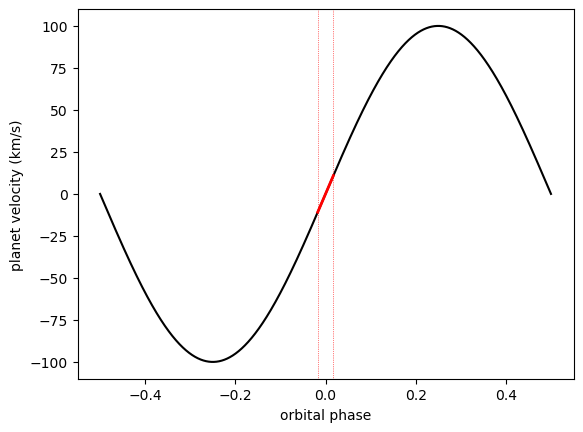

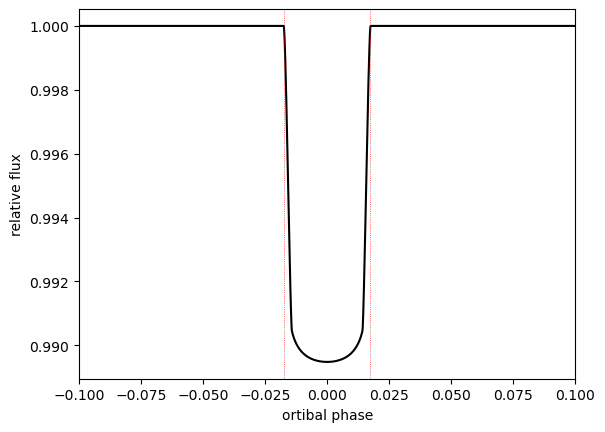

In [2]:
#We will simulate a typical planetary transit observation
#First define the velocity information
Period = 3 #days - orbital period of the planet
Kp = 100 #km/s #velocity amplitude of the planets orbit - 100 km/s is typical for a hot Jupiter

#define time/phase etc
time = np.linspace(-1.5,1.5,10000)
phase = time / Period
vp = Kp*np.sin(phase*2.*np.pi) # planet's velocity for full orbit

#we also need to get a transit function
# (you don't need to worry about the details here for now)
RpRs = 0.1 #planet to star flux ratio
b = 0.1 #impact parameter
aRs = 10 #system scale a/Rs (semi-major axis in units of Rstar)
c1,c2 = 0.1,0.1 # limb darkening parameters
tpar = [0,Period,aRs,RpRs,b,c1,c2,1,0] #define transit paramters
tdur = Period / np.pi * np.arcsin(np.sqrt( 1./aRs**2 + RpRs**2 / aRs*2 - (b/aRs)**2)) #get transit duration

#compute the transit - this requires installed software, so will save for now
# import MyFuncs as MF
# flux = MF.Transit_aRs(tpar,time) 
# flux[(phase<-0.3)+(phase>0.3)] = 1. #filter out 2ndary eclipses
# np.save('full_transit.npy',flux)
flux = np.load('full_transit.npy')

#get in-transit index
t_ind = (time>-tdur/2.)*(time<tdur/2.)

plt.figure()
plt.plot(phase,vp,'k-')
plt.plot(phase[t_ind],vp[t_ind],'r-',lw=2)
plt.axvline(-tdur/2./Period,lw=0.5,color='r',ls=':')
plt.axvline(+tdur/2./Period,lw=0.5,color='r',ls=':')
plt.xlabel('orbital phase')
plt.ylabel('planet velocity (km/s)')
plt.figure()
plt.plot(phase,flux,'k-')
plt.axvline(-tdur/2./Period,lw=0.5,color='r',ls=':')
plt.axvline(+tdur/2./Period,lw=0.5,color='r',ls=':')
plt.xlabel('ortibal phase')
plt.ylabel('relative flux')
plt.xlim(-0.1,0.1)

### Now we can create a more realistic abosrption signal for a real dataset

Note that we're going to ignore the *continuum* absorption, as it's removed from real datasets during pre-processing.

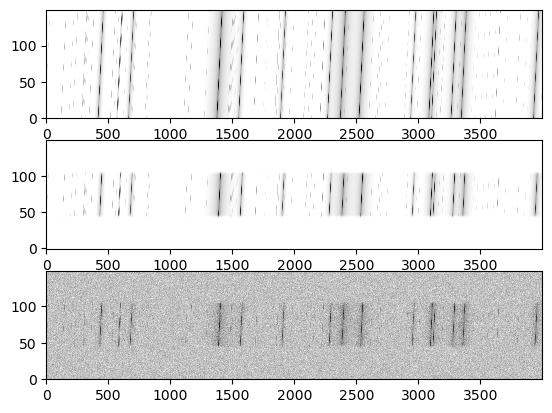

In [3]:
#get the model transmission spectrum from before
wl_template,template = np.load('model_FeI_2500K.npy')

#define wavelength and phase of observations
wl = np.linspace(3700,3700+60,4000)
ph = np.linspace(-0.04,0.04,150) #orbital phase - several minutes cadence is typical

#get transit model (we'll now ignore limb darkening, as it's wavelength dependent)
tpar = [0,Period,aRs,RpRs,b,0,0,1,0] #define transit paramters
# import MyFuncs as MF
# flux = MF.Transit_aRs(tpar,ph*Period) 
# np.save('transit.npy',flux)
tmodel = np.load('transit.npy')

#compute planet velocity for each orbital phase
vp = Kp*np.sin(ph*2.*np.pi)

#create array of wavelengths and interpolate transmission spectrum to new grid
W = np.outer(1.-vp*1000./const.c.value,wl)
S = np.interp(W,wl_template,template)

#finally, we will weight the signal proportional to the trasnit
tweight = (1. - tmodel) / np.ptp(tmodel)
Sw = S * tweight[...,np.newaxis]

#let's also subtract the median over each column - this is to replicate some pre-processing required for real data
Sw -= np.median(Sw,axis=0)

#add some noise to signal to make a more realistic dataset
X = Sw + np.random.normal(0,0.0001,S.shape)

#make a plot of the arrays
f,a = plt.subplots(3)
a[0].imshow(S)
a[1].imshow(Sw)
a[2].imshow(X)



Note that this assumes that we have already removed the signal from the star. In real data, we have to perform some pre-processing to get to this stage. Depending on the amount of noise we add, we may see the trace of the planet's lines in the simulated data. In reality, we will only see the trace once we do cross-correlation, and often only after we sum over the planet's velocity.

### Now we can try and boost the signal using our cross-correlation techniques



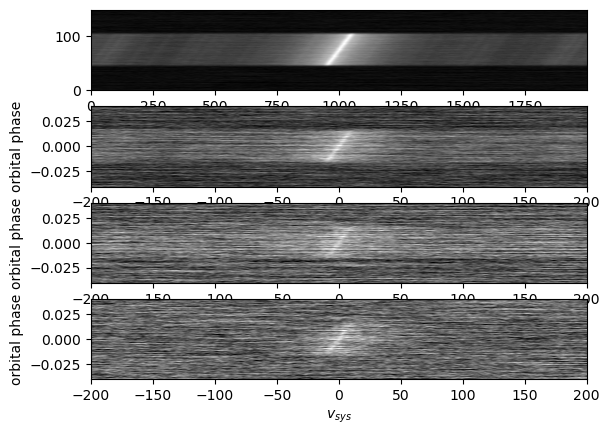

In [4]:
#create the same shifted templates as before
v_sys = np.linspace(-200,200,2000) #define range to perform cc
c = const.c.value #get speed of light
W = np.outer((1-v_sys*1000./c),wl) #create array of shifted wavelengths for each v_sys
shifted_templates = np.interp(W,wl_template,template-template.mean()) #interpolate the template model to every v_sys

#and compute all of the cross correlation functions in one line
CC = np.dot(X,shifted_templates.T)

#make a plot of the ccf
f,a = plt.subplots(4)
a[0].imshow(CC)

#try again with a fainter signal - we won't see the aliases typically
CC = np.dot(Sw + np.random.normal(0,0.001,S.shape),shifted_templates.T)
a[1].pcolormesh(v_sys,ph,CC)
a[1].set_xlabel(r'$v_{sys}$')
a[1].set_ylabel(r'orbital phase')

#for an even fainter signal, we will not see the trail in velocity
#  - we have to sum over the velocity of the planet to see it!
CC_faint = np.dot(Sw + np.random.normal(0,0.002,S.shape),shifted_templates.T)
a[2].pcolormesh(v_sys,ph,CC_faint)
a[2].set_xlabel(r'$v_{sys}$')
a[2].set_ylabel(r'orbital phase')

# let's make a final plot but subtracting the median of the cc function in each row
# this is sometimes good for visualisation, and removes some of the arbitrary offsets between successive CC functions
a[3].pcolormesh(v_sys,ph,CC_faint-np.median(CC_faint,axis=1)[:,np.newaxis])
a[3].set_xlabel(r'$v_{sys}$')
a[3].set_ylabel(r'orbital phase')

#save the data to work on later
np.savez('CC_funcs.npz',CC=CC,CC_faint=CC_faint,v_sys=v_sys,ph=ph,tmodel=tmodel)


### Explore further

This is a simple simulation of a time-series transit obsevation, after pre-processing the data. See Figure 1 of [Gibson et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.2215G/abstract) for an example. The simulated data would be simlar to the bottom left panel, and the CCF vs time array to the upper right/middle right panels. In this case, you can faintly see the trail of the Fe I signal, but only after we've summed over multiple spectral orders.

Often, we do not see the trail in the CCF vs time/phase. Therefore we also need to sum over the velocity trail of the planet - this further boosts the signal by summing the data over time. In addition, we do not know the exact planet velocity (which varies with the mass of the star, which is known to typically only ~10%), so we have to sum over a range of $K_p$ to produce a $K_p-v_{sys}$ cross-correaltion map (bottom right panel of paper). Using the cross-correlation and interpolation methods you've learnt, you should now be able to produce such a map.

Here are a few further things to try:
- Sum up the phase-CC array over the planet's velocity, to boost the CC signal (Hint: interpolate back to the planet's rest frame)
- How should the sum be weighted over time? (to account for the transit shape)
- Try doing this for various values of $K_p$ to produce a $K_p-v_{sys}$ map (Hint: use a range of Kp = np.linspace(-150,150,600))
- Think about how you might adjust the method if you have time-wavelength varying noise (as in reality)

Once you are happy with applying these methods to simulated datasets, you are ready to start applying them to real data!